# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [2]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

import difflib
import re
import numpy as np

In [3]:
PATH_TO_DATA = Path('C:/Users/Armand/Desktop/3A/Deep Learning/nlp_project/nlp_project/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [4]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt',encoding="utf8") as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        #return self.embeddings[self.word2id[word]]
        try:
            i = self.word2id[word]
            return self.embeddings[i]
        except:
            try:
                word = difflib.get_close_matches(word, self.words)[0]
                i = self.word2id[word]
            except:
                return 0
        return self.embeddings[i]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        code1=self.encode(word1)
        code2=self.encode(word2)
        return np.dot(code1,code2)/(np.linalg.norm(code1)*np.linalg.norm(code2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        
        scores=[] #list of index and scores
        for index,w2 in enumerate(self.words):
            scores.append((self.score(word,w2),index))
        sorted_scores=sorted(scores,reverse = True)
        k_similar_index=[s[1] for s in sorted_scores[:k]]
        k_similar_words=[self.words[i] for i in k_similar_index]
        return k_similar_words

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'pup', 'canine']
['dogs', 'dog', 'cats', 'puppies', 'Dogs']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg']


In [5]:
class BagOfWords():
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf={}
        N=len(sentences)
        
        # get number of documents containing each word
        for sentence in sentences:
            wordsList=re.sub("[^\w]", " ",sentence).split()
            for word in set(wordsList):
                idf[word]=idf.get(word, 0)+1
                
        #transform to get idf value of each word       
        for word in idf:
            idf[word]=np.log10(N/idf[word])
        return idf
        
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        wordsList=re.sub("[^\w]", " ",sentence).split()
        wordsVectors=[self.word2vec.encode(word) for word in wordsList]
        if idf is None:
            # mean of word vectors
            return np.mean(wordsVectors,axis=0)
        else:
            # idf-weighted mean of word vectors
            weightedMean=0
            sumIdf=0
            for i,word in enumerate(wordsList):
                weightedMean+=idf.get(word,0)*wordsVectors[i]
                sumIdf+=idf.get(word,0)
            weightedMean=weightedMean/sumIdf
            return weightedMean
                                

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        code1=self.encode(sentence1,idf)
        code2=self.encode(sentence2,idf)
        return np.dot(code1,code2)/(np.linalg.norm(code1)*np.linalg.norm(code2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        scores=[]
        for sentence2 in sentences:
            scores.append(self.score(sentence,sentence2,idf))
            #see progression
            if len(scores)%10000==0:
                print(round(100*len(scores)/len(sentences)),"% of scores computed")
        k_similar_index = np.argpartition(np.array(scores), -k)[-k:]
        k_similar_index = k_similar_index[np.argsort([-scores[i] for i in k_similar_index])]
        k_similar_sentences=[sentences[i] for i in k_similar_index]
        return k_similar_sentences

In [91]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6415914630303108
7 % of scores computed
13 % of scores computed
20 % of scores computed
27 % of scores computed
33 % of scores computed
40 % of scores computed
46 % of scores computed
53 % of scores computed
60 % of scores computed
66 % of scores computed
73 % of scores computed
80 % of scores computed
86 % of scores computed
93 % of scores computed
100 % of scores computed
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) 3 males and 1 woman enjoying a sporting event 
5) 2 chinese people wearing traditional clothes 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6366631124436564
7 % of scores 

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [6]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        X=[]
        Y=[]
        for word in self.fr_word2vec.words:
            if word in self.en_word2vec.words:
                if len(X)>0:
                    X=np.hstack((X,np.array([self.fr_word2vec.encode(word)]).T))
                    Y=np.hstack((Y,np.array([self.en_word2vec.encode(word)]).T))
                else:
                    X=np.array([self.fr_word2vec.encode(word)]).T
                    Y=np.array([self.en_word2vec.encode(word)]).T
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, s, Vt=np.linalg.svd(np.dot(Y,X.T))
        W=np.dot(U,Vt)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        #fr_word_emb = self.fr_word2vec.encode(fr_word)
        #en_word_emb = np.dot(W,fr_word_emb.T)
        en_word_emb=self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]]
        
        scores=[] #list of index and scores
        for index,en_word2_emb in enumerate(self.en_word2vec.embeddings):
            score=np.dot(en_word_emb,en_word2_emb)/(np.linalg.norm(en_word_emb)*np.linalg.norm(en_word2_emb))
            scores.append((score,index))
        sorted_scores=sorted(scores,reverse = True)
        k_similar_index=[s[1] for s in sorted_scores[:k]]
        k_similar_words=[self.en_word2vec.words[i] for i in k_similar_index]
        return k_similar_words

In [44]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [7]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath ='SST/stsa.fine.train'
dev_filepath ='SST/stsa.fine.dev'
test_filepath ='SST/stsa.fine.test.X'

def read_file(path,is_test=False):
    with open(path, "r") as p:
        if is_test==False:
            lines = p.read().split("\n")[:-1]
            labels = np.array([int(line[0]) for line in lines])
            sentences = [line[2:] for line in lines]
            return sentences, labels
        else:
            sentences = p.read().split("\n")[:-1]
            return sentences

train_sentences=read_file(train_filepath)[0]
train_labels=read_file(train_filepath)[1]
dev_sentences=read_file(dev_filepath)[0]
dev_labels=read_file(dev_filepath)[1]
test_sentences=read_file(test_filepath,is_test=True)

In [92]:
# 2 - Encode sentences with the BoV model above

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

#idf weighted embeddings
idf = sentence2vec.build_idf(train_sentences+dev_sentences)
train_sentences_emb=[sentence2vec.encode(train_sentences[i],idf) for i in range(len(train_sentences))]
dev_sentences_emb=[sentence2vec.encode(dev_sentences[i],idf) for i in range(len(dev_sentences))]
test_sentences_emb=[sentence2vec.encode(test_sentences[i],idf) for i in range(len(test_sentences))]

#mean of words embeddings
train_sentences_mean_emb=[sentence2vec.encode(train_sentences[i]) for i in range(len(train_sentences))]
dev_sentences_mean_emb=[sentence2vec.encode(dev_sentences[i]) for i in range(len(dev_sentences))]
test_sentences_mean_emb=[sentence2vec.encode(test_sentences[i]) for i in range(len(test_sentences))]

Loaded 50000 pretrained word vectors


C:\Users\Armand\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [115]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import LogisticRegression

#idf weighted embeddings
train_acc,dev_acc=[],[]
pen_values = 10.0**(np.arange(-2,2,0.5))

for pen in pen_values:
    logReg = LogisticRegression(penalty="l2",C = pen,multi_class='auto',solver='newton-cg')
    logReg.fit(train_sentences_emb, train_labels)
    train_acc.append(logReg.score(train_sentences_emb, train_labels))
    dev_acc.append(logReg.score(dev_sentences_emb, dev_labels))

best_pen=pen_values[np.argmax(dev_acc)]
best_train_acc=train_acc[np.argmax(dev_acc)]
best_dev_acc=max(dev_acc)

print("Results for idf-weighted BoW: \n","Best value for the penalty:",best_pen,'\n Dev accuracy:',best_dev_acc,'\n Train accuracy:',best_train_acc)

#mean of words embeddings
train_acc,dev_acc=[],[]

for pen in pen_values:
    logReg = LogisticRegression(penalty="l2",C = pen, multi_class='auto',solver='newton-cg')
    logReg.fit(train_sentences_mean_emb, train_labels)
    train_acc.append(logReg.score(train_sentences_mean_emb, train_labels))
    dev_acc.append(logReg.score(dev_sentences_mean_emb, dev_labels))

best_pen=pen_values[np.argmax(dev_acc)]
best_train_acc=train_acc[np.argmax(dev_acc)]
best_dev_acc=max(dev_acc)

print("Results for mean BoW: \n","Best value for the penalty:",best_pen,'\n Dev accuracy:',best_dev_acc,'\n Train accuracy:',best_train_acc)

Results for idf-weighted BoW: 
 Best value for the penalty: 10.0 
 Dev accuracy: 0.3923705722070845 
 Train accuracy: 0.4648876404494382
Results for mean BoW: 
 Best value for the penalty: 10.0 
 Dev accuracy: 0.3941871026339691 
 Train accuracy: 0.4598548689138577


In [108]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

#train our best model on all the data
logReg = LogisticRegression(penalty="l2",C = best_pen, multi_class='auto',solver='newton-cg')
logReg.fit(train_sentences_mean_emb+dev_sentences_mean_emb, list(train_labels)+list(dev_labels))

#make predictions
label_predictions=logReg.predict(test_sentences_mean_emb)
np.savetxt('logreg_bov_y_test_sst.txt', label_predictions, fmt= '%d')


In [109]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# I try LGBM classifier

from lightgbm import LGBMClassifier

#idf weighted embeddings
train_acc,dev_acc=[],[]
num_leaves_values = np.arange(15,40,5)

for leaves in num_leaves_values:
    clf = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100,num_leaves=leaves)
    clf.fit(train_sentences_emb, train_labels)
    train_acc.append(clf.score(train_sentences_emb, train_labels))
    dev_acc.append(clf.score(dev_sentences_emb, dev_labels))

best_nb_leaves=num_leaves_values[np.argmax(dev_acc)]
best_train_acc=train_acc[np.argmax(dev_acc)]
best_dev_acc=max(dev_acc)

print("Results for idf-weighted BoW: \n","Best value for nb of leaves:",best_nb_leaves,'\n Dev accuracy:',best_dev_acc)

#mean of words embeddings
train_acc,dev_acc=[],[]

for leaves in num_leaves_values:
    clf = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100,num_leaves=leaves)
    clf.fit(train_sentences_mean_emb, train_labels)
    train_acc.append(clf.score(train_sentences_mean_emb, train_labels))
    dev_acc.append(clf.score(dev_sentences_mean_emb, dev_labels))

best_nb_leaves=num_leaves_values[np.argmax(dev_acc)]
best_train_acc=train_acc[np.argmax(dev_acc)]
best_dev_acc=max(dev_acc)

print("Results for idf-weighted BoW: \n","Best value for nb of leaves:",best_nb_leaves,'\n Dev accuracy:',best_dev_acc)

Results for idf-weighted BoW: 
 Best value for nb of leaves: 25 
 Dev accuracy: 0.3905540417801998
Results for idf-weighted BoW: 
 Best value for nb of leaves: 35 
 Dev accuracy: 0.3678474114441417


In [111]:
#train our best model on all the data
clf = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100,num_leaves=leaves)
clf.fit(train_sentences_mean_emb+dev_sentences_mean_emb, list(train_labels)+list(dev_labels))

#make predictions
label_predictions=clf.predict(test_sentences_mean_emb)
np.savetxt('lgbm_bov_y_test_sst.txt', label_predictions, fmt= '%d')

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [9]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
from keras.preprocessing.text import one_hot

nb_words = 10000
train_onehot = [one_hot(sentence, nb_words) for sentence in train_sentences]
dev_onehot = [one_hot(sentence, nb_words) for sentence in dev_sentences]
test_onehot = [one_hot(sentence, nb_words) for sentence in test_sentences]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [10]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

maxseqlen = max(map(len, train_onehot + dev_onehot + test_onehot))
x_train = pad_sequences(train_onehot, padding = 'post', truncating = 'post', maxlen = maxseqlen)
x_dev = pad_sequences(dev_onehot, padding = 'post', truncating = 'post', maxlen = maxseqlen)
x_test = pad_sequences(test_onehot, padding = 'post', truncating = 'post', maxlen = maxseqlen)

y_train = to_categorical(train_labels)
y_dev = to_categorical(dev_labels)

## 4.2 - Design and train your model

In [33]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 100  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 10000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

In [34]:
# 4 - Define your loss/optimizer/metrics
from keras import optimizers

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
opt      =  'rmsprop' #'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=opt,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 1,042,565
Trainable params: 1,042,565
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 16
n_epochs = 10

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 31s 4ms/sample - loss: 1.4531 - accuracy: 0.3512 - val_loss: 1.4964 - val_accuracy: 0.3315
Epoch 2/10
8544/8544 [==============================] - 27s 3ms/sample - loss: 1.4338 - accuracy: 0.3743 - val_loss: 1.4805 - val_accuracy: 0.3678
Epoch 3/10
8544/8544 [==============================] - 27s 3ms/sample - loss: 1.4241 - accuracy: 0.3944 - val_loss: 1.4799 - val_accuracy: 0.3869
Epoch 4/10
8544/8544 [==============================] - 30s 3ms/sample - loss: 1.4159 - accuracy: 0.3929 - val_loss: 1.4665 - val_accuracy: 0.3833
Epoch 5/10
8544/8544 [==============================] - 31s 4ms/sample - loss: 1.3883 - accuracy: 0.4086 - val_loss: 1.4340 - val_accuracy: 0.3315
Epoch 6/10
8544/8544 [==============================] - 25s 3ms/sample - loss: 1.3558 - accuracy: 0.4263 - val_loss: 1.4417 - val_accuracy: 0.3915
Epoch 7/10
8544/8544 [==============================] - 24s 3ms/sample

Text(0, 0.5, 'Accuracy')

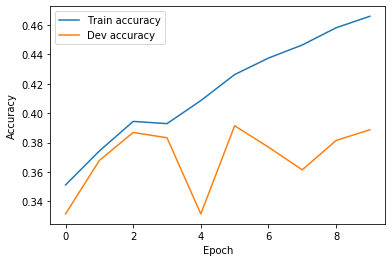

In [43]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

#we use the last model because it was the one with the lowest validation loss
y_test = model.predict(x_test)
text = "\n".join(y_test.max(axis=1).astype(str))
file = open("logreg_lstm_y_test_sst.txt", "w")
file.write(text)
file.close()

import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Dev accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## 4.3 - innovate !

In [14]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# I tried to pretrain the lookup table, but the performance was bad

#build embedding matrix with the embeddings from word2vec
word2vec = Word2Vec(en_embeddings_path, vocab_size=10000)

embedding_matrix = np.zeros((10000, 300))
for i, emb in enumerate(word2vec.embeddings):
    embedding_matrix[i] = emb
    
#use the same model as before, with pretrained vectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 10000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size,embed_dim,weights=[embedding_matrix],trainable=False))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

# Defineloss/optimizer/metrics
from keras import optimizers

loss_classif     =  'categorical_crossentropy' 
opt      =  'adam'
metrics_classif  =  ['accuracy']

# Compile
model.compile(loss=loss_classif,
              optimizer=opt,
              metrics=metrics_classif)
print(model.summary())

#train model
bs = 16
n_epochs = 5

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

#predictions
y_test = model.predict(x_test)
text = "\n".join(y_test.max(axis=1).astype(str))
file = open("pretrained_lstm_y_test_sst.txt", "w")
file.write(text)
file.close()

Loaded 10000 pretrained word vectors
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 3,093,765
Trainable params: 93,765
Non-trainable params: 3,000,000
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 38s 4ms/sample - loss: 1.5752 - accuracy: 0.2706 - val_loss: 1.5722 - val_accuracy: 0.2625
Epoch 2/5
8544/8544 [==============================] - 31s 4ms/sample - loss: 1.5700 - accuracy: 0.2622 - val_loss: 1.5727 - val_accu